In [1]:
import PIL

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import Model

In [2]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [3]:
for layer in vgg.layers:
    print(f"{layer.name}-->{layer.output_shape}")

input_1-->[(None, 224, 224, 3)]
block1_conv1-->(None, 224, 224, 64)
block1_conv2-->(None, 224, 224, 64)
block1_pool-->(None, 112, 112, 64)
block2_conv1-->(None, 112, 112, 128)
block2_conv2-->(None, 112, 112, 128)
block2_pool-->(None, 56, 56, 128)
block3_conv1-->(None, 56, 56, 256)
block3_conv2-->(None, 56, 56, 256)
block3_conv3-->(None, 56, 56, 256)
block3_conv4-->(None, 56, 56, 256)
block3_pool-->(None, 28, 28, 256)
block4_conv1-->(None, 28, 28, 512)
block4_conv2-->(None, 28, 28, 512)
block4_conv3-->(None, 28, 28, 512)
block4_conv4-->(None, 28, 28, 512)
block4_pool-->(None, 14, 14, 512)
block5_conv1-->(None, 14, 14, 512)
block5_conv2-->(None, 14, 14, 512)
block5_conv3-->(None, 14, 14, 512)
block5_conv4-->(None, 14, 14, 512)
block5_pool-->(None, 7, 7, 512)
flatten-->(None, 25088)
fc1-->(None, 4096)
fc2-->(None, 4096)
predictions-->(None, 1000)


In [4]:
#Gram matrix
def g_m(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
    g_m = tf.expand_dims(result,axis=0)
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1]*input_shape[2],tf.float32)
    return g_m/i_j

In [5]:
#Processing image through VGG
def load_vgg(vgg):
    vgg.trainable=False
    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
    content_output = vgg.get_layer(content_layers[0]).output
    style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]
    gram_style_output = [g_m(output_) for output_ in style_output]
    model = Model([vgg.input], [content_output, gram_style_output])
    return model

In [6]:
#Total Loss
def loss_object(style_output,content_output,style_target,content_target,style_weight=1e-1,content_weight=1e-4):
    content_loss = tf.reduce_mean((content_output-content_target)**2)
    style_loss = [tf.reduce_mean((output_-target_)**2) for output_,target_ in zip(style_output,style_target)]
    style_loss = tf.add_n(style_loss)
    total_loss = content_weight*content_loss + style_weight*style_loss
    return total_loss
    

In [7]:
opt = tf.optimizers.Adam(learning_rate=0.01,beta_1=0.99,epsilon=1e-1)

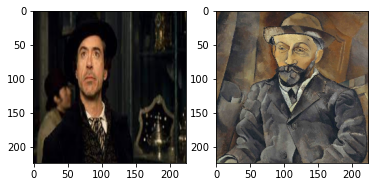

In [16]:
%matplotlib inline
content_image = cv.imread('style.jpg')
content_image = cv.resize(content_image,(224,224))
content_image = tf.image.convert_image_dtype(content_image,tf.float32)

style_image = cv.imread('picaso.jpg')
style_image = cv.resize(style_image,(224,224))
style_image = tf.image.convert_image_dtype(style_image,tf.float32)

plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(np.array(content_image),cv.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(np.array(style_image),cv.COLOR_BGR2RGB))
plt.show()

In [17]:
vgg_model = load_vgg(vgg)
content_target = vgg_model(np.array([content_image*255]))[0]
style_target = vgg_model(np.array([style_image*255]))[1]

In [18]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [19]:
def train_step(image, epoch):
    with tf.GradientTape() as tape:
        output = vgg_model(image*255)
        loss = loss_object(output[1], output[0], style_target, content_target)
    gradient = tape.gradient(loss, image)
    opt.apply_gradients([(gradient, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

    if epoch % 100 ==0:
        tf.print(f"Loss = {loss}")


In [21]:
EPOCHS = 150
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
    train_step(image, i)

Loss = 10625828864.0
Loss = 562952000.0


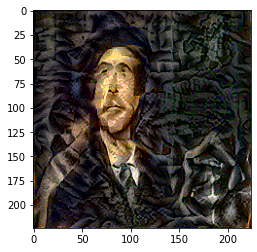

In [13]:
import PIL
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
plt.imshow(cv.cvtColor(np.array(tensor), cv.COLOR_BGR2RGB))
plt.show()

In [14]:
tensor = np.array(tensor, dtype=np.uint8)
cv.imwrite('gen.jpg',tensor)